Import Statements

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import optuna
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
import shap

df = pd.read_csv("titanictrain.csv")
testdf = pd.read_csv("titanictest.csv")

Data Cleaning

Describing the "training" dataset

In [ ]:
print(df.info())
print(df.describe())
print(df.shape)

# Cabin only has 204/891 elements
# Age has only 714/891 elements
# 2 missing from Embarked

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.48659

Describing the "test" dataset

In [ ]:
print(testdf.info())
print(testdf.describe())
print(testdf.shape)

# Cabin only has 91/418 elements
# Age has only 332/418 elements
# 1 missing from Fare

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB
None
       PassengerId      Pclass         Age       SibSp       Parch        Fare
count   418.000000  418.000000  332.000000  418.000000  418.000000  417.000000
mean   1100.500000    2.265550   30.272590    0.447368    0.392344   35.627188
std     120.810458    0.841838   14.181209  

Ttest for different distributions

In [ ]:
from scipy.stats import ttest_ind_from_stats

num1, mean1, std1 = 418, 35.627188, 55.907576
num2, mean2, std2 = 891, 32.204208, 49.693429

print(ttest_ind_from_stats(mean1, std1, num1, mean2, std2, num2))

# After testing, none of the features are intrinsically different distributed

Ttest_indResult(statistic=np.float64(1.1155550340787665), pvalue=np.float64(0.26481771216506367))


Crosstabs (test)

In [ ]:
pd.crosstab(df["Embarked"], df["Survived"])

Survived,0,1
Embarked,,
C,75,93
Q,47,30
S,427,217


In [ ]:
pd.crosstab(df["Sex"], df["Survived"])

Survived,0,1
Sex,,
female,81,233
male,468,109


In [9]:
pd.crosstab(df.loc[df["Age"].isna(), "Sex"], df["Survived"])

Survived,0,1
Sex,,
female,17,36
male,108,16


Feature Engineering

In [ ]:
# Extra missing value stuff

df["Embarked"] = df["Embarked"].fillna("S")

df["Sex"] = df["Sex"].map({"male": 0, "female": 1}).astype(int)
testdf["Sex"] = testdf["Sex"].map({"male": 0, "female": 1}).astype(int)

df["Age_Missing"] = df["Age"].isna().astype(int)
testdf["Age_Missing"] = testdf["Age"].isna().astype(int)

# Slight relationship between C / Q and surviving, but not much for Embarked Places

# Try to extract the "Title" from the "Name", manually one hot encode

# This finds the title

df["Title"] = df["Name"].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
testdf["Title"] = testdf["Name"].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]


def AcceptedTitles(name):
    if name in ["Miss", "Mrs", "Mr", "Master"]:
        return name
    return "Other"


df["Title"] = df["Title"].apply(AcceptedTitles)
testdf["Title"] = testdf["Title"].apply(AcceptedTitles)

df = pd.get_dummies(df, columns=["Embarked", "Title"], dtype=int)
testdf = pd.get_dummies(testdf, columns=["Embarked", "Title"], dtype=int)

# Ticket Features are unnecessary, group together sibsp+parch

df["SibSp+Parch"] = df["SibSp"] + df["Parch"]
testdf["SibSp+Parch"] = testdf["SibSp"] + testdf["Parch"]

# Try to extract the "Letter" from Cabin, which is ordinal


def extraction(string):
    if isinstance(string, str) and len(string) > 0:
        return 1
    return 0


df["HasCabin"] = df["Cabin"].apply(extraction)
testdf["HasCabin"] = testdf["Cabin"].apply(extraction)

# There seems little point in one hot encoding, the categories are pretty superfluous

# Drop "Unnecessary" columns and put aside the "target" column

target = df["Survived"]
sd = testdf["PassengerId"]
df = df.drop(columns=["Name", "Cabin", "Survived", "PassengerId", "Ticket", "SibSp", "Parch", "Title_Miss"])
testdf = testdf.drop(columns=["Name", "Cabin", "PassengerId", "Ticket", "SibSp", "Parch", "Title_Miss"])

Title_Miss vs. Title_Mrs (Testing which feature to drop, in this case Title_Miss)

In [ ]:
pd.crosstab(df["Title_Mrs"], target)

In [ ]:
pd.crosstab(df["Title_Miss"], target)

Imputations / Missing Values

In [ ]:
testdf["Fare"] = testdf["Fare"].fillna(df.groupby("Pclass")["Fare"].transform("median"))

Age Distributions

In [14]:
df["Age_Missing"] = df["Age"].isna()
testdf["Age_Missing"] = testdf["Age"].isna()

SibSp+Parch Testing

In [ ]:
pd.crosstab(df["SibSp+Parch"], target)

# Don't include the
df["FamilySize_1-3"] = (df["SibSp+Parch"] >= 1) & (df["SibSp+Parch"] <= 3).astype(int)
df["FamilySize_4+"] = (df["SibSp+Parch"] >= 4).astype(int)

testdf["FamilySize_1-3"] = (testdf["SibSp+Parch"] >= 1) & (testdf["SibSp+Parch"] <= 3).astype(int)
testdf["FamilySize_4+"] = (testdf["SibSp+Parch"] >= 4).astype(int)

df = df.drop(columns=["SibSp+Parch"])
testdf = testdf.drop(columns=["SibSp+Parch"])

Correlation Matrix

In [16]:
print(df.describe())
print(testdf.describe())

           Pclass         Sex         Age        Fare  Embarked_C  Embarked_Q  \
count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000   
mean     2.308642    0.352413   29.699118   32.204208    0.188552    0.086420   
std      0.836071    0.477990   14.526497   49.693429    0.391372    0.281141   
min      1.000000    0.000000    0.420000    0.000000    0.000000    0.000000   
25%      2.000000    0.000000   20.125000    7.910400    0.000000    0.000000   
50%      3.000000    0.000000   28.000000   14.454200    0.000000    0.000000   
75%      3.000000    1.000000   38.000000   31.000000    0.000000    0.000000   
max      3.000000    1.000000   80.000000  512.329200    1.000000    1.000000   

       Embarked_S  Title_Master    Title_Mr   Title_Mrs  Title_Other  \
count  891.000000    891.000000  891.000000  891.000000   891.000000   
mean     0.725028      0.044893    0.580247    0.140292     0.030303   
std      0.446751      0.207186    0.493796    0.34748

Age "Binning"

In [ ]:
df["Age"], newbins = pd.qcut(df["Age"], 10, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], retbins=True)

testdf["Age"] = pd.cut(
    testdf["Age"],
    bins=[0.42, 14.0, 19.0, 22.0, 25.0, 28.0, 31.8, 36.0, 41.0, 50.0, 80.0],
    labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
)

print(pd.crosstab(df["Age"], target))

print(newbins)

# No need to "bin" Fare

df = pd.get_dummies(df, columns=["Age"], dtype=int)
testdf = pd.get_dummies(testdf, columns=["Age"], dtype=int)

Survived   0   1
Age             
0         32  45
1         53  34
2         48  19
3         44  26
4         37  24
5         40  26
6         47  44
7         34  19
8         47  31
9         42  22
[ 0.42 14.   19.   22.   25.   28.   31.8  36.   41.   50.   80.  ]


HeatMap / Correlation Matrix

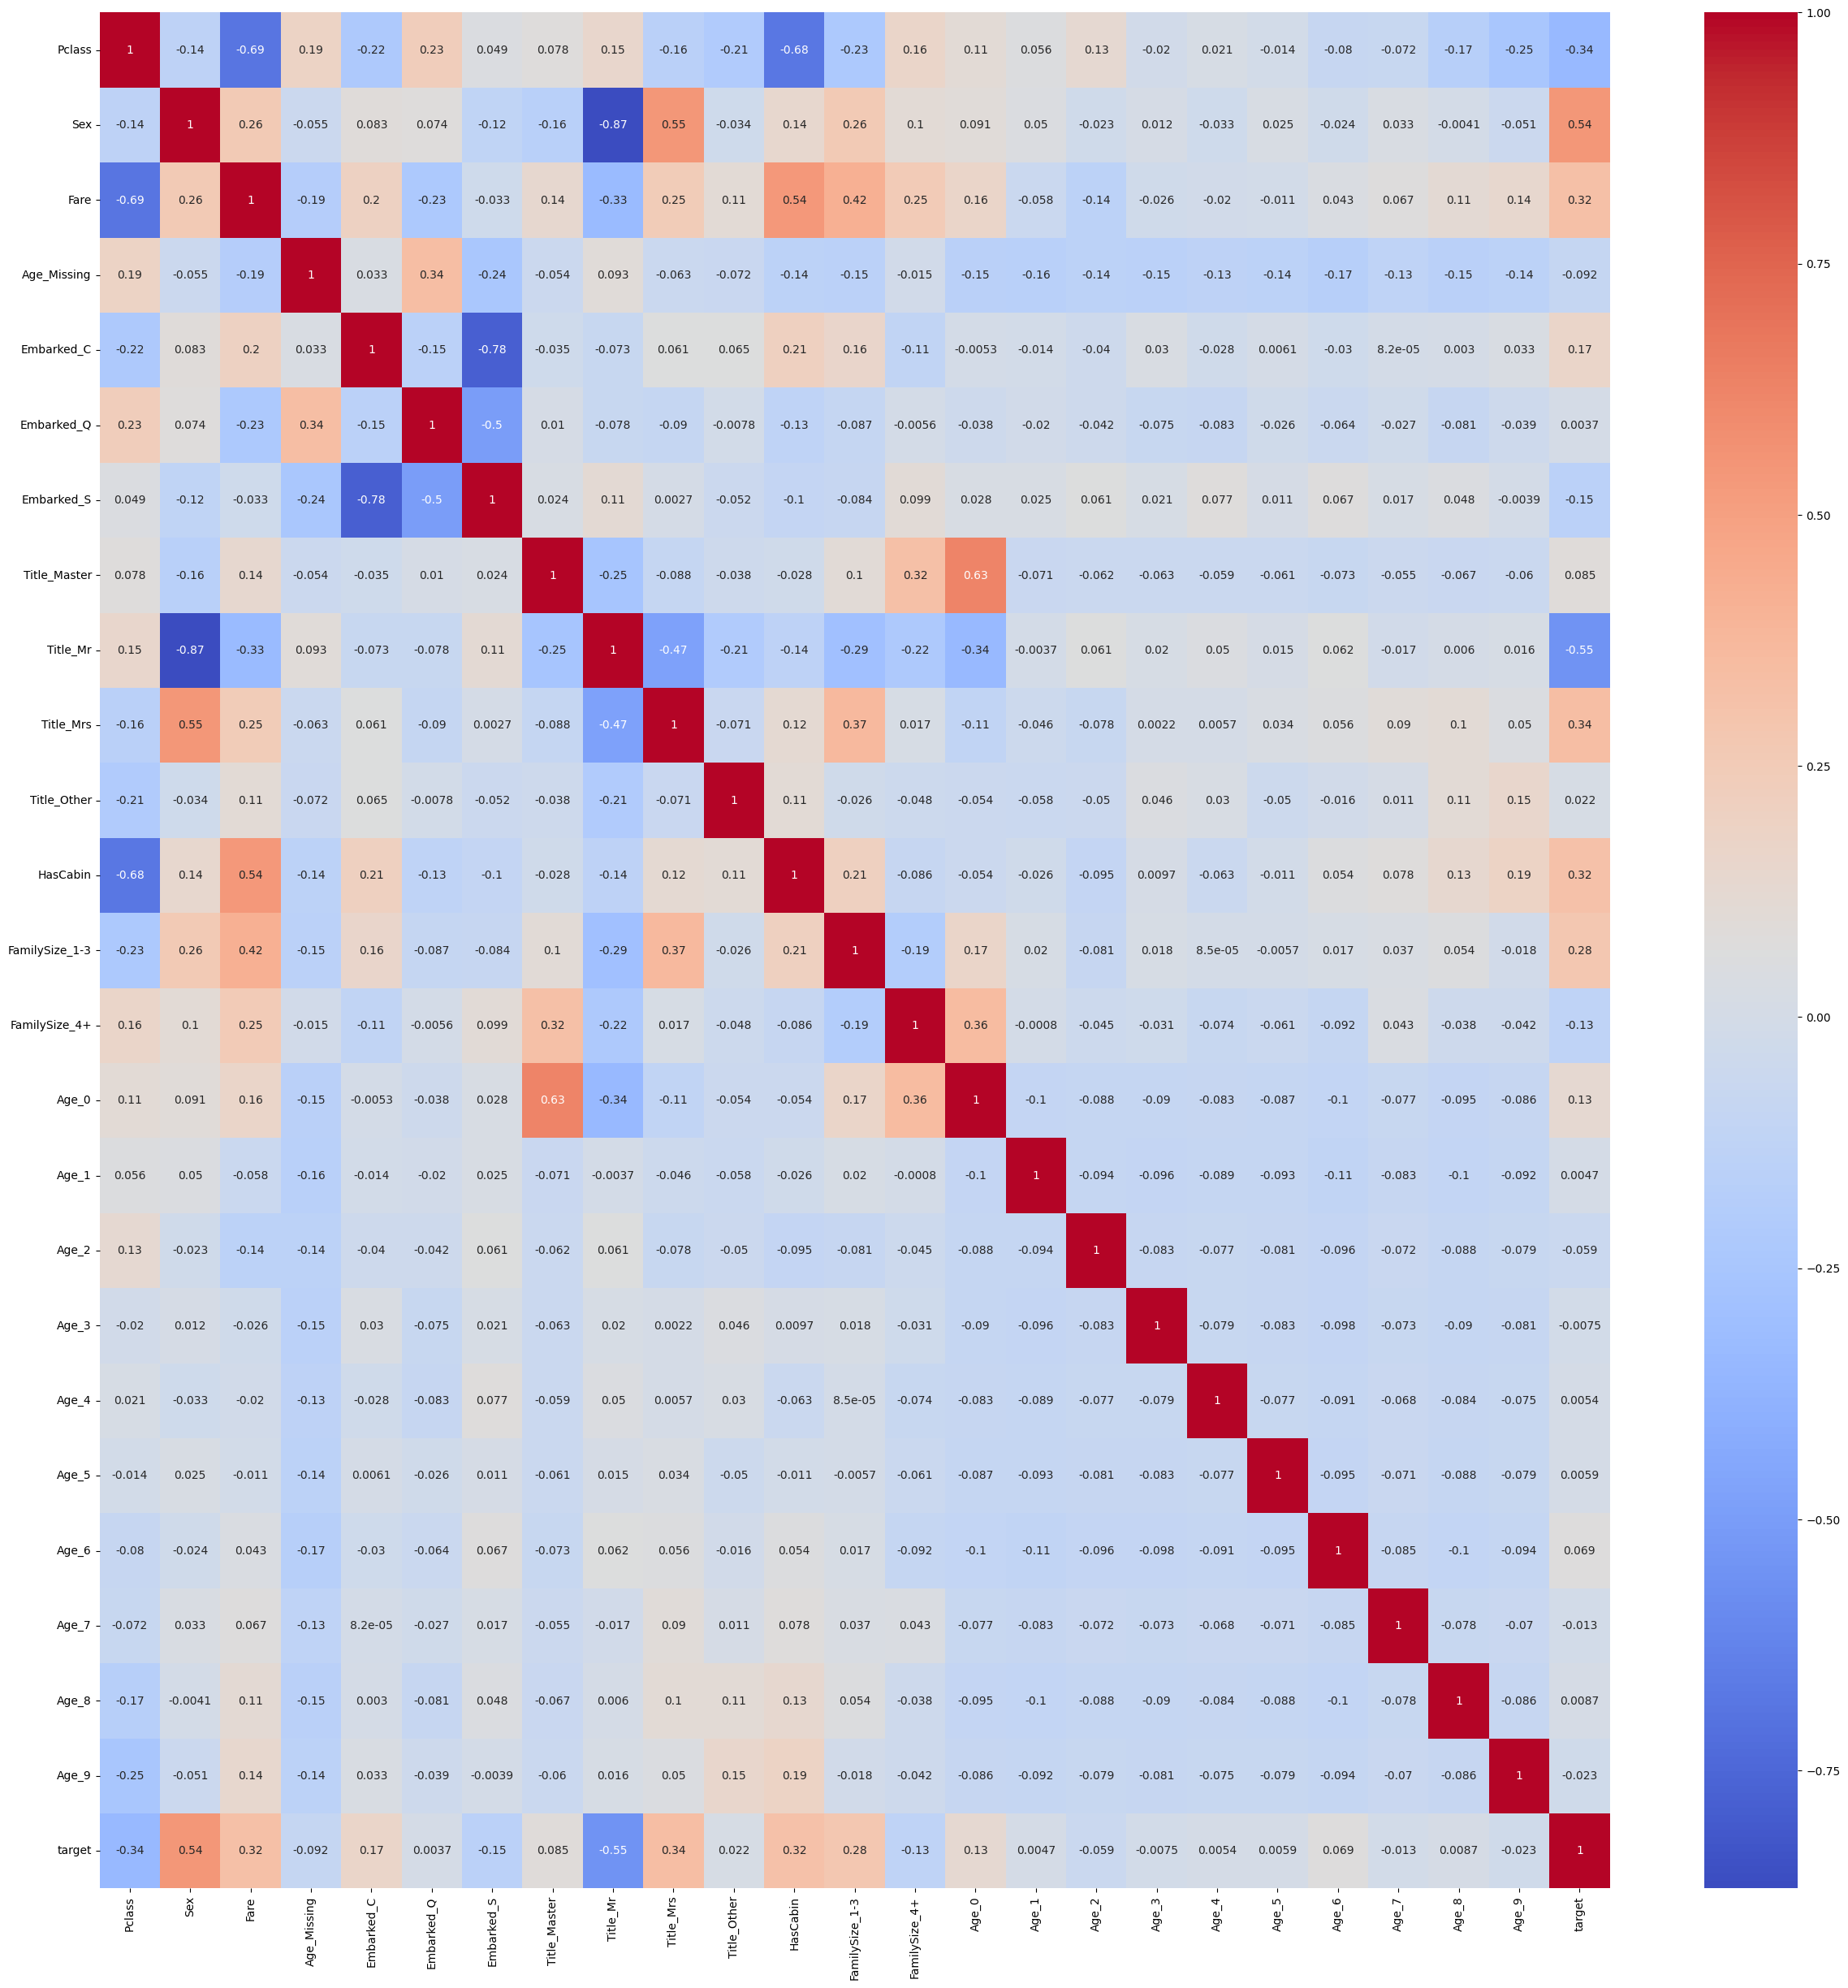

In [ ]:
# Fill Ages with the "Correct" Imputations (Grouped Medians)

lol = df.copy()

lol["target"] = target

corr_matrix = lol.corr(method="spearman")

plt.figure(figsize=(30, 30))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

Quick CV Check

In [ ]:
model = RandomForestClassifier(random_state=2102)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=76)

basescores = cross_val_score(model, df, target, cv=cv, scoring="accuracy")
print(np.mean(basescores), np.std(basescores))
for x in df.columns:

    scores = cross_val_score(model, df.drop(columns=[x]), target, cv=cv, scoring="accuracy")
    print(x, np.mean(scores), np.std(scores))

# Starting to doubt "Embarked" as an important feature

0.8136902893729208 0.008295199480630747
Pclass 0.8069487163392128 0.013233501441740608
Sex 0.8103257799259305 0.008238677511019157
Fare 0.8125855250768941 0.011288234690315658
Age_Missing 0.817048521750047 0.01059348110625429
Embarked_C 0.8215554579122465 0.011343511070939288
Embarked_Q 0.8125729709371665 0.007537697231272079
Embarked_S 0.8204318624066286 0.011139608007004193
Title_Master 0.8204318624066286 0.00994190773165862
Title_Mr 0.8148138848785387 0.012817656776021948
Title_Mrs 0.817048521750047 0.01275619521481082
Title_Other 0.8103257799259307 0.01249993949376222
HasCabin 0.821542903772519 0.00669510635605999
FamilySize_1-3 0.8215303496327915 0.009964037299244232
FamilySize_4+ 0.8204255853367648 0.009409254444196278


KeyboardInterrupt: 

Model (Just going to assume test and train sets are similar)

In [ ]:
def objective(trial):
    # Define the hyperparameters you want to search
    n_estimators = trial.suggest_int("n_estimators", 350, 600)
    max_depth = trial.suggest_int("max_depth", 4, 6)
    min_samples_split = trial.suggest_int("min_samples_split", 3, 5)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 6)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    # Initialize the model with the current trial's hyperparameters
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=0,
        n_jobs=-1,
    )

    # Use cross-validation to evaluate performance
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=76)
    scores = cross_val_score(clf, df, target, cv=cv, scoring="accuracy")
    return np.mean(scores)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Best result
print("Best hyperparameters:", study.best_trial.params)
print("Best CV accuracy:", study.best_value)

[I 2025-08-04 13:41:14,932] A new study created in memory with name: no-name-cbf0976c-3268-4048-a272-2632186d2006
[W 2025-08-04 13:41:14,993] Trial 0 failed with parameters: {'n_estimators': 423, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.13/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/m6/q45h0_z963j3ym37k0m8vx1h0000gq/T/ipykernel_1576/628225579.py", line 22, in objective
    scores = cross_val_score(clf, df, target, cv=cv, scoring="accuracy")
  File "/opt/homebrew/lib/python3.13/site-packages/sklearn/utils/_param_validation.py", line 216, in wrapper
    return func(*args, **kwargs)
  File "/opt/homebrew/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 684, in cross_val_score
    cv_results = cross_validate(
        estima

KeyboardInterrupt: 

In [ ]:
model1 = RandomForestClassifier(
    n_estimators=500, max_depth=4, min_samples_split=5, min_samples_leaf=2, max_features="log2", random_state=0
)

s1 = cross_val_score(model1, df, target, cv=cv, scoring="accuracy")

print(s1.mean(), s1.std())

0.830525390747599 0.017922935070275828


SHAP Values

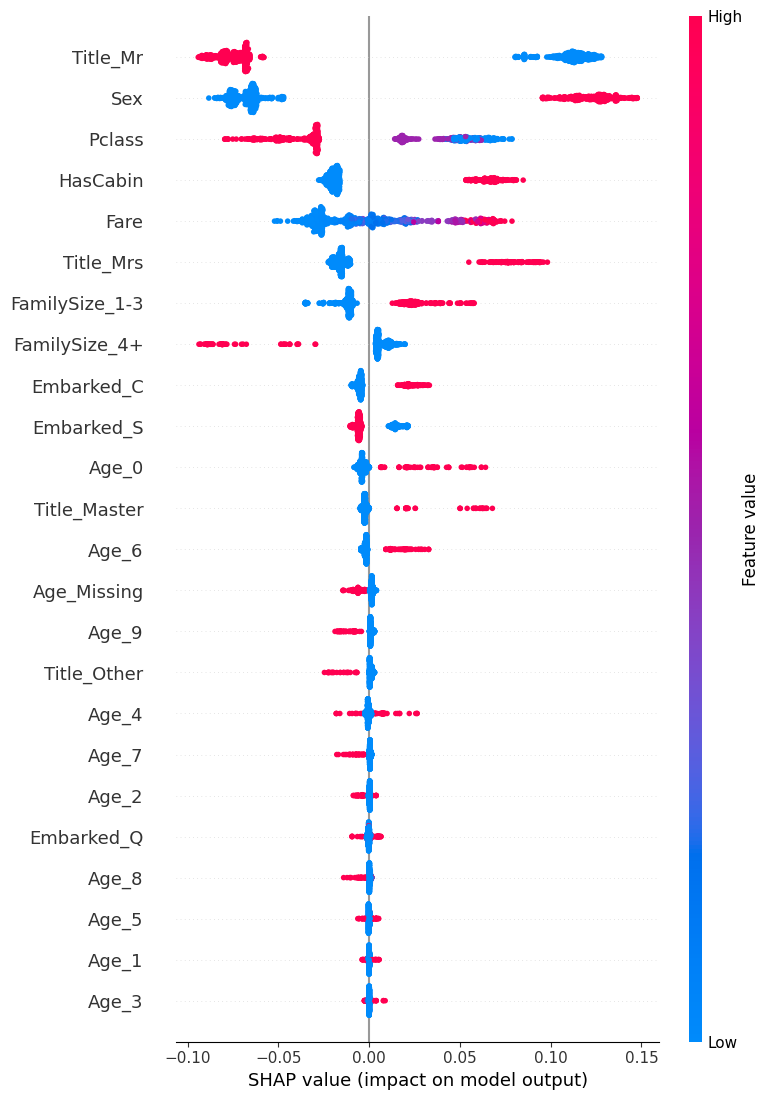

<Figure size 640x480 with 0 Axes>

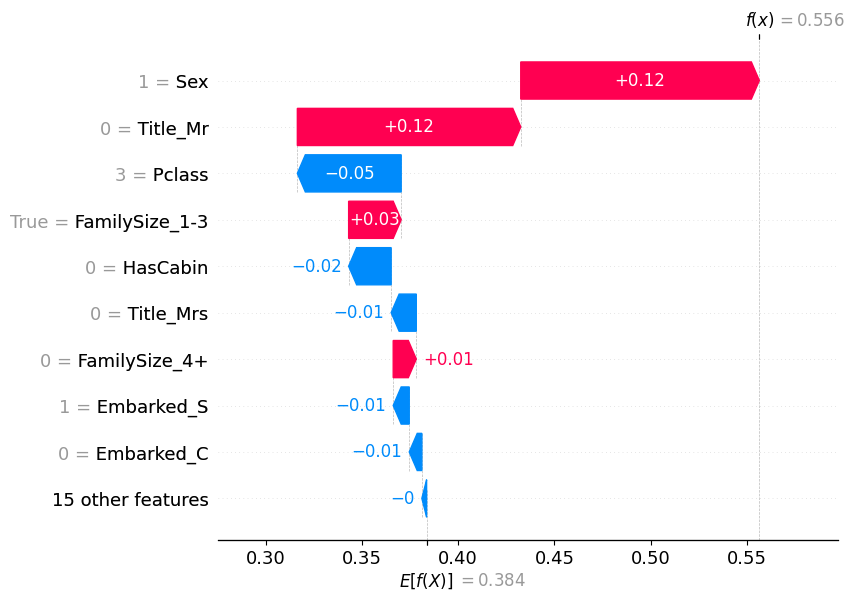

0


In [ ]:
model1.fit(df, target)

explainer = shap.TreeExplainer(model1)
shap_values = explainer.shap_values(df)

shap.summary_plot(shap_values[:, :, 1], df, max_display=len(df.columns))

plt.tight_layout()
plt.show()

explainer = shap.TreeExplainer(model1)
shap_values = explainer(df)  # Note: explainer(df), not explainer.shap_values(df)

# This shows mean SHAP values (not absolute)

index = 38

shap.plots.waterfall(shap_values[:, :, 1][index])
print(target[index])
plt.show()

In [ ]:
probabilities = model1.predict_proba(df)

prob_df = pd.DataFrame(probabilities, columns=model1.classes_, index=df.index)
pd.set_option("display.max_rows", None)
print(prob_df)

            0         1
0    0.843742  0.156258
1    0.090311  0.909689
2    0.500944  0.499056
3    0.102324  0.897676
4    0.854508  0.145492
5    0.844319  0.155681
6    0.689958  0.310042
7    0.737627  0.262373
8    0.413307  0.586693
9    0.157285  0.842715
10   0.323411  0.676589
11   0.259738  0.740262
12   0.863496  0.136504
13   0.860826  0.139174
14   0.496449  0.503551
15   0.252034  0.747966
16   0.765259  0.234741
17   0.833009  0.166991
18   0.397529  0.602471
19   0.378611  0.621389
20   0.799554  0.200446
21   0.697544  0.302456
22   0.438536  0.561464
23   0.605181  0.394819
24   0.650819  0.349181
25   0.619112  0.380888
26   0.842196  0.157804
27   0.655120  0.344880
28   0.441241  0.558759
29   0.869196  0.130804
30   0.561652  0.438348
31   0.087674  0.912326
32   0.444759  0.555241
33   0.841337  0.158663
34   0.659561  0.340439
35   0.718256  0.281744
36   0.841526  0.158474
37   0.863496  0.136504
38   0.443516  0.556484
39   0.349120  0.650880
40   0.460670  0

Final Fittings

In [ ]:
print(model1.feature_importances_)

print(df.columns)

answers = model1.predict(testdf)
submission = pd.DataFrame({"PassengerId": sd.astype(int), "Survived": answers})

# Save to CSV
submission.to_csv("submission.csv", index=False)

[0.09466894 0.24786373 0.09783085 0.00451616 0.01334708 0.00347884
 0.01227772 0.0119472  0.24711823 0.08324875 0.0044399  0.06121676
 0.0393882  0.03288308 0.018303   0.00201447 0.00157011 0.00229388
 0.00484219 0.00208168 0.00602346 0.00197214 0.00267594 0.0039977 ]
Index(['Pclass', 'Sex', 'Fare', 'Age_Missing', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Title_Master', 'Title_Mr', 'Title_Mrs', 'Title_Other',
       'HasCabin', 'FamilySize_1-3', 'FamilySize_4+', 'Age_0', 'Age_1',
       'Age_2', 'Age_3', 'Age_4', 'Age_5', 'Age_6', 'Age_7', 'Age_8', 'Age_9'],
      dtype='object')
